# Preliminary

In [1]:
import numpy as np
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
y_feat = 'y'
s = bank_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)

X_train, X_test, y_train, y_test = train_test_split(bank_ds[cat_feats+real_feats], bank_ds[y_feat].apply(lambda x: {'no':0,'yes':1}[x]))

train_pool = cb.Pool(X_train, y_train, cat_features=cat_feats)
test_pool = cb.Pool(X_test, y_test, cat_features=cat_feats)
bb = cb.CatBoostClassifier()
bb.fit(train_pool, verbose=False, plot=False)

train_preds, test_preds = bb.predict(train_pool), bb.predict(test_pool)
train_preds_proba, test_preds_proba = bb.predict_proba(train_pool)[:,1], bb.predict_proba(test_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'test':m(y_test, test_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(), 'test':y_test.mean(), 'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train','test'])
metrics_ds

,metrics,train,test
0,accuracy_score,0.939823,0.908930
1,precision_score,0.872510,0.642105
2,recall_score,0.560102,0.469231
3,y_mean,0.115339,0.114943


# First thought on interpretation

## The task

The goal is to identify what features are the most important for the model predictions. I.e. what exact feature changes affect predictions the most. And, if possible, what exact feature _values_ changes affect predictions the most.
The interpretation should somehow use Formal Concept Analysis. As example the result of the interpretation should be presented as a Concept Lattice.

A model to interpret is supposed to be a Black Box, i.e. one knows nothing about its internal structure. The only known things are:
* input data $X$ (the set of features and their values needed for the model to run)
* Black Box model as a function $BB: X \mapsto Y$, where $Y$ is prediction of the model.

## Benefits of FCA

Formal Concept is a mathematical structure though may be useful for business analysis. Some features in the original dataset may correspond to the same business value. To resolve this one can either change the input data and the model (not our case) or somehow consider it at the stage of interpreting the model. The latter can be done with assigning specific values of different features to the same Formal Concept.

## Lack of FCA

FCA is good for interpreting the result though it's not always the best model to predict the result. So consider the given Black Box model is the model possible model to solve the task via some metric. Therefore FCA should be used only to interpret the Black Box rather then predicting its output.

## Ways to interpret

There are 2 basic ways to interpret a model:
1. Global - what features are the most important in the model given data $X$. The outcome is the set of features ordered by their contribution to all the rows of data.
2. Local - what features are the most important in the model for given row (object) $g\in X$. The output is the set of features ordered by their contribution into specific rox $x$ of data. If possible - how exactly did they influence the prediction.

## Ideas of intepretation

### One feature noise
For every feature $f \in F$ ($F$ is the set of all features), change the values of $f$ to some noise and calculate $$\Delta Y_f=\frac{1}{|G|} |\{g\in G| |BB(g_f)-BB(g)|>k\}|  $$, 
where
* $g_f$ - data with nosed feature $f$,
* $g$ - the default data,
* $k$ - some coefficient corresponding to the precision of the interpretation,
* $|*|$ - cardinality of a set

Then construct the context 

In [4]:
def predict_with_noise(fs, X, model, cat_feats, random_state=142, predict_proba=False):
    if type(fs)==str:
        fs = [fs]
    for f in fs:
        if f in cat_feats:
            X[f] = np.random.choice(X[f].unique(), size=len(X))
        else:
            X[f] = np.random.uniform(X[f].min(), X[f].max(),size=len(X))
    pool = cb.Pool(X, cat_features=cat_feats)
    preds = model.predict_proba(pool)[:,1] if predict_proba else model.predict(pool)
    return preds

#### 1. How much does it correlate with actual feature importances

Calculate some aggregated statisctics over difference between original and noised predictions

In [5]:
res_ds = []
for f in tqdm_notebook(cat_feats+real_feats):
    for rs in tqdm_notebook(range(100), leave=True, desc=f, disable=True):
        diff = train_preds_proba - predict_with_noise(f, X_train, bb, cat_feats, random_state=rs, predict_proba=True)
        res = {'random_state':rs, 'feature':f, 'dataset':'train',
              'mean_diff':np.abs(diff).mean(), 'median_diff':np.median(np.abs(diff)), 'max_diff':np.abs(diff).max(), 'min_diff':np.abs(diff).min()}
        res_ds.append(res)
        
        diff = test_preds_proba - predict_with_noise(f, X_test, bb, cat_feats, random_state=rs, predict_proba=True)
        res = {'random_state':rs, 'feature':f, 'dataset':'test',
              'mean_diff':np.abs(diff).mean(), 'median_diff':np.median(np.abs(diff)), 'max_diff':np.abs(diff).max(), 'min_diff':np.abs(diff).min()}
        res_ds.append(res)
res_ds = pd.DataFrame(res_ds)
res_ds.head()

,dataset,feature,max_diff,mean_diff,median_diff,min_diff,random_state
0,train,job,0.310981,0.007151,0.000753,0.0,0
1,test,job,0.282264,0.007374,0.000824,0.0,0
2,train,job,0.308852,0.007235,0.000749,0.0,1
3,test,job,0.271186,0.006931,0.000838,0.0,1
4,train,job,0.304888,0.007306,0.000765,0.0,2


Actual feature importances given by Black Box model (CatBoost has implemented feature importances evaluation algorithm)

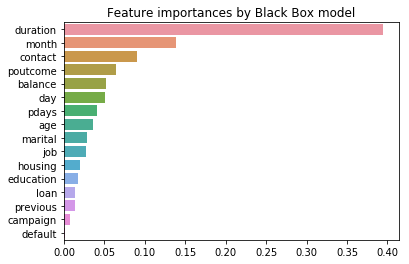

In [6]:
bb_imps = pd.Series(bb.get_feature_importance(type='PredictionValuesChange'), index=bb.feature_names_).sort_values(ascending=False)
bb_imps /= bb_imps.sum()
sns.barplot(x=bb_imps.values, y=bb_imps.index)
plt.title('Feature importances by Black Box model')
plt.show()

Do train and test metrics differ much?

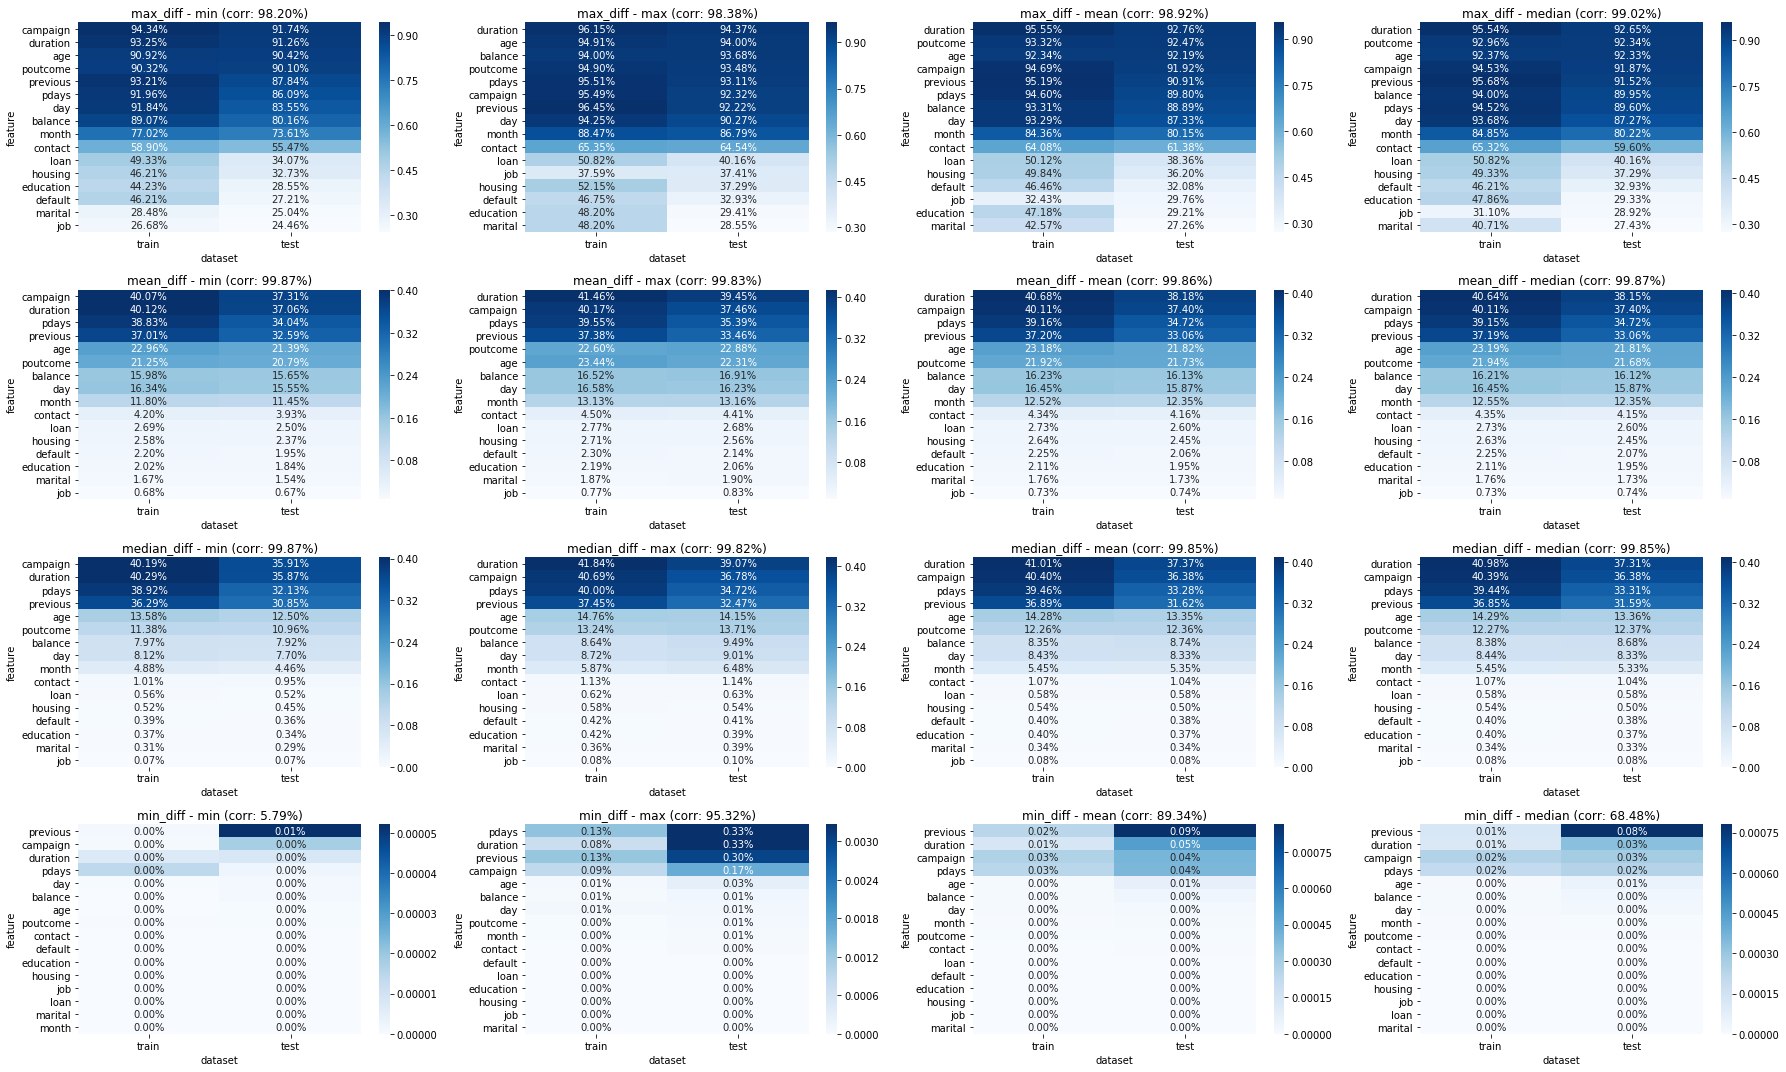

In [7]:
plt.figure(figsize=(25,15))
for idx_x, af in enumerate(['min','max','mean','median']):
    for idx_y, m in enumerate(res_ds.drop(['dataset','feature','random_state'],1).columns):
        cds = res_ds.pivot_table(index='feature', columns='dataset', values=m, aggfunc=af)
        cds = cds.reindex(columns=['train','test']).sort_values('test',ascending=False)

        plt.subplot((res_ds.shape[1]-3), 4, idx_y*4+idx_x+1)
        plt.title(f"{m} - {af} (corr: {cds.corr().values[0,1]:.2%})")
        sns.heatmap(cds, annot=True, cmap='Blues', fmt='.2%')
        
plt.tight_layout()
plt.show()

Actualy, now. So we can use just the test dataset

Calculate Shap Values (one of the most popular interpretation method)

In [8]:
sv = pd.DataFrame(bb.get_feature_importance(data=test_pool, type='ShapValues'), columns=list(test_pool.get_feature_names())+['bias'])
sv.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,duration,campaign,pdays,previous,bias
0,0.025032,-0.053920,0.019010,-0.000240,-0.125609,0.043826,-0.561332,-0.205045,-0.178449,-0.032219,0.239407,0.067802,-2.335366,0.023372,-0.021874,-0.033291,-3.449088
1,-0.082686,-0.175486,-0.032889,-0.001494,0.145726,-0.250995,0.242996,-0.167168,-0.142371,-0.021112,-0.014251,0.081659,0.887658,-0.168000,0.001996,-0.033334,-3.449088
2,0.039388,0.136047,0.011842,-0.000856,-0.125521,0.043040,-0.623885,-0.486195,-0.167130,-0.024641,-0.205839,-0.168200,-2.140881,0.011413,-0.022384,-0.027785,-3.449088
3,-0.089788,-0.171613,0.024710,0.000434,-0.117634,0.046803,0.258561,-0.205570,-0.138832,-0.020662,-0.006950,0.004615,-0.446436,0.034249,0.017584,-0.034962,-3.449088
4,0.029305,0.177221,0.002083,-0.000730,0.171253,0.038878,0.235374,-0.215018,-0.141699,0.043655,-0.621829,-0.024019,0.817063,0.015509,-0.006191,-0.025400,-3.449088


Now compare results of different aggregations:

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


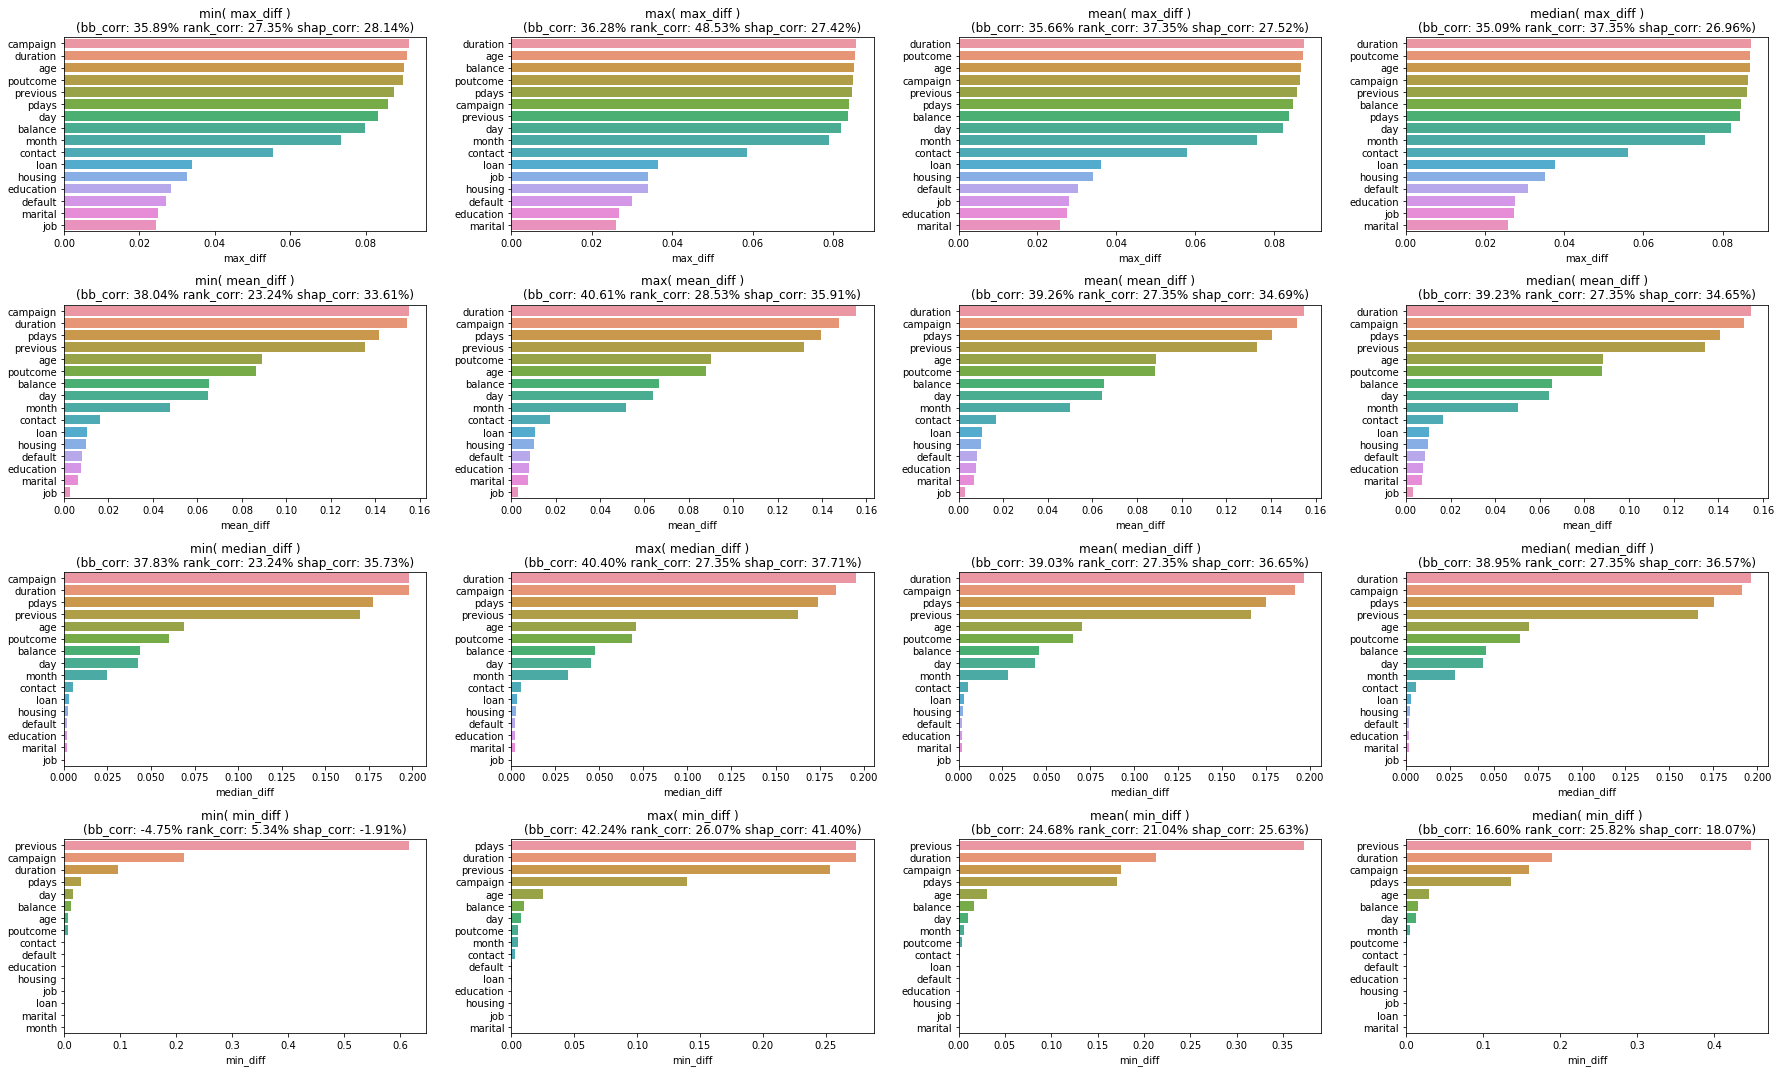

In [9]:
plt.figure(figsize=(25,15))
for idx_x, af in enumerate(['min','max','mean','median']):
    for idx_y, m in enumerate(res_ds.drop(['dataset','feature','random_state'],1).columns):
        cds = res_ds[res_ds['dataset']=='test'].groupby('feature').agg({m:af})
        cds = pd.concat([sv.drop('bias',1).abs().mean(), cds, bb_imps],1)
        cds.columns = ['shap',m, 'bb']
        cds /= cds.sum()
        
        cds = cds.sort_values(m,ascending=False)
        
        plt.subplot((res_ds.shape[1]-3), 4, idx_y*4+idx_x+1)
        title = f"{af}( {m} )\n("+\
                f"bb_corr: {np.corrcoef(cds[m],cds['bb'])[0,1]:.2%} " +\
                f"rank_corr: {np.corrcoef(cds[m].rank(),cds['bb'].rank())[0,1]:.2%} " +\
                f"shap_corr: {np.corrcoef(cds[m],cds['shap'])[0,1]:.2%}" +\
                ")"
        plt.title(title)
        sns.barplot(x=m, y=cds.index, data=cds)
        #sns.heatmap(cds, annot=True, cmap='Blues', fmt='.2%')
        
plt.tight_layout()
plt.show()

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


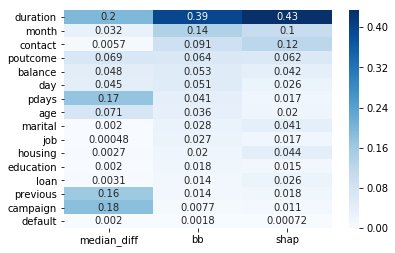

In [10]:
m,af = 'median_diff','max'
cds = res_ds[res_ds['dataset']=='test'].groupby('feature').agg({m:af})
cds = pd.concat([ cds, bb_imps,sv.drop('bias',1).abs().mean(),],1)
cds.columns = [m,'bb','shap']
cds /= cds.sum()
cds = cds.sort_values('bb',ascending=False)
sns.heatmap(cds, cmap='Blues', annot=True)

Our method is not perfectly correlated as it's quite simple compared to CatBoost feature importance (which uses internal model structure) and Shap values (which has great game theory background).

#### 2. Try to apply FCA

In [11]:
context = pd.DataFrame(index=X_test.index, columns=X_test.columns)
for f in tqdm_notebook(context.columns):
    context[f] = np.mean(np.abs([test_preds_proba-predict_with_noise(f, X_test, bb, cat_feats, random_state=rs, predict_proba=True) for rs in range(100)]),0)

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


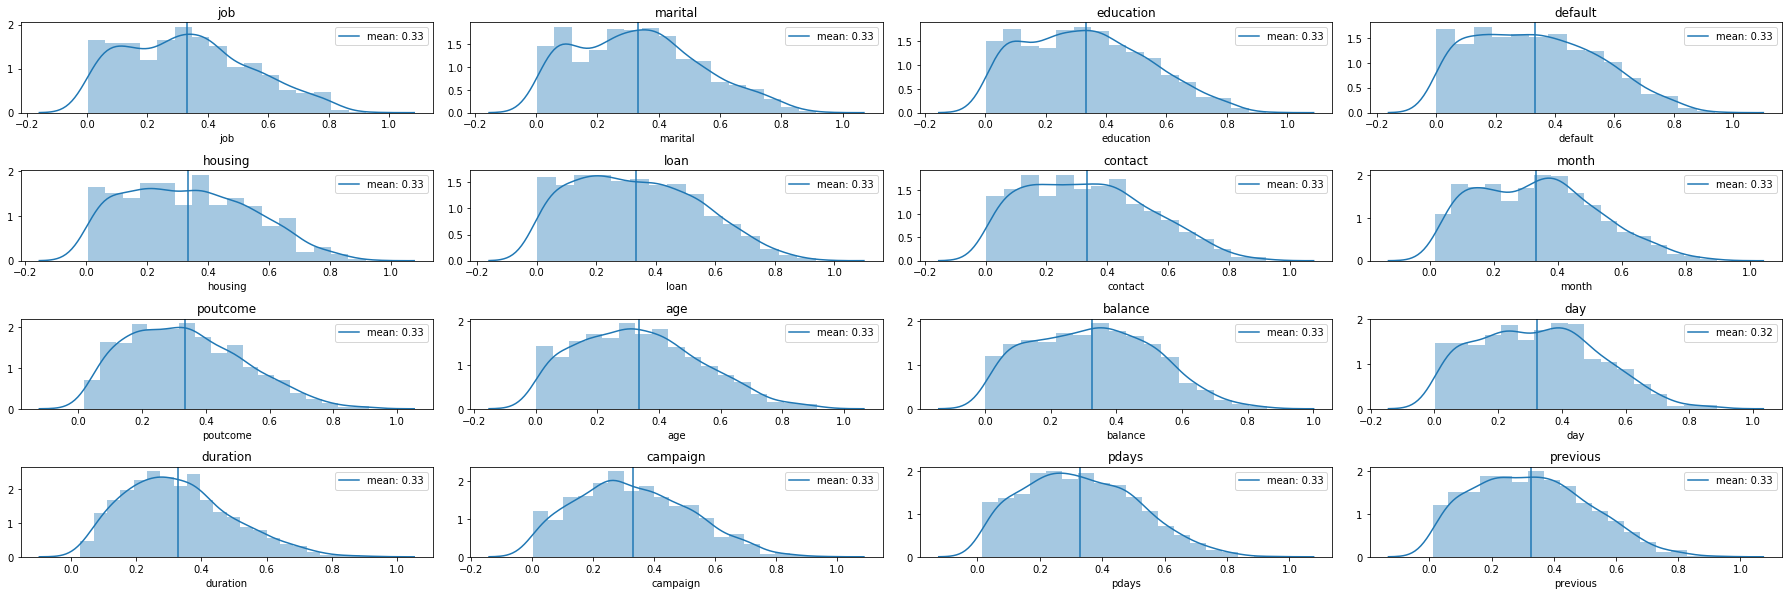

In [12]:
plt.figure(figsize=(25,10))
for idx,f in enumerate(context.columns):
    plt.subplot(context.shape[1]//4+1,4,idx+1)
    sns.distplot(context[f])
    plt.axvline(context[f].mean(), label=f'mean: {context[f].mean():.2f}')
    plt.legend()
    plt.title(f)
plt.tight_layout()
plt.show()

In [13]:
s = {}
for f in context.columns:
    s[f] = np.corrcoef(context[f], sv[f].abs())[0,1]
s = pd.Series(s).sort_values(ascending=False)
s

housing      0.108174
campaign     0.092088
contact      0.025094
poutcome     0.025055
loan         0.021027
marital      0.019160
pdays       -0.005086
balance     -0.020131
day         -0.043450
default     -0.044212
education   -0.044505
job         -0.045966
age         -0.049410
previous    -0.062613
duration    -0.093883
month       -0.103894
dtype: float64

Obtained values are much uncorrelated with Shap Values for every feature. Still we'll try to use them

Firstly, binarize the context into standart Formal Context

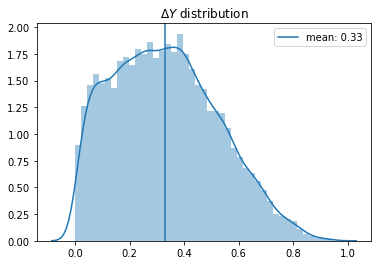

In [14]:
sns.distplot(context.values.flatten())
m = context.values.flatten().mean()
plt.axvline(m, label=f'mean: {m:.2f}')
plt.legend()
plt.title('$\Delta Y$ distribution')
plt.show()

Choose Binarization threshold to 0.41 as it is mean difference of noised and original predictions

In [15]:
thresh = 0.41
context_bin = context.copy()
context_bin[context_bin>=thresh] = 1
context_bin[context_bin<thresh] = 0
context_bin = context_bin.astype(bool)
print(context_bin.shape)
context_bin.head()

(1131, 16)


,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,duration,campaign,pdays,previous
833,True,False,True,True,False,False,False,True,True,True,True,True,False,True,True,True
3017,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False
1782,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
3704,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
368,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [16]:
import concepts

In [17]:
def get_extent(cur_attrs, cntx, attrs_dict=None):
    assert attrs_dict is None or len(attrs_dict)==cntx.shape[1], 'Attributes dict should cover all columns of the Context and vice versa'
    
    attr_idxs = list(cur_attrs) if type(cur_attrs)==tuple else [cur_attrs] if type(cur_attrs)!=list else cur_attrs
    attr_idxs = [attrs_dict[m] for m in attr_idxs] if attrs_dict is not None else attr_idxs
    
    ext = np.arange(cntx.shape[0])
    ext = list(ext[cntx[:,attr_idxs].sum(1)==len(attr_idxs)])
    return ext

In [18]:
def get_intent(cur_objs, cntx, objs_dict=None):
    assert objs_dict is None or len(objs_dict)==cntx.shape[0], 'Objects dict should cover all rows of the Context and vice versa'
    
    obj_idxs = list(cur_objs) if type(cur_objs)==tuple else [cur_objs] if type(cur_objs)!=list else cur_objs
    obj_idxs = [objs_dict[g] for g in obj_idxs] if objs_dict is not None else obj_idxs

    int_ = np.arange(cntx.shape[1])
    cntx = cntx[obj_idxs]
    int_ = list(int_[cntx.sum(0)==len(obj_idxs)])
    return int_

In [19]:
attrs_dict = {m:i for i,m in enumerate(context_bin.columns)}
objs_dict = {g:i for i,g in enumerate(context_bin.index)}
context_bin_matr = context_bin.values.astype(bool)

In [20]:
context_bin_matr[[0,1,2,3,4,5]]

array([[ True, False,  True,  True, False, False, False,  True,  True,
         True,  True,  True, False,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False]])

In [21]:
#idxs = context_bin.sample(100, random_state=42).index
idxs = context_bin.index
objects = list(idxs)
properties = list(context_bin.columns)
bools = list(context_bin.loc[idxs].fillna(False).astype(bool).itertuples(index=False, name=None))
c_ = concepts.Context(objects, properties, bools)

In [22]:
from itertools import combinations, islice

In [23]:
from datetime import datetime

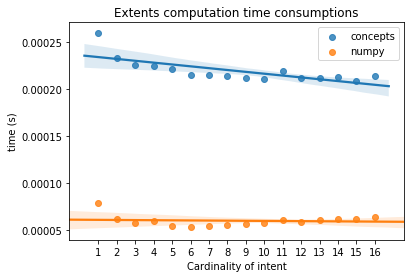

In [24]:
xaxis = list(range(1,len(context_bin.columns)+1))
y_conc = []
y_pand = []

for x in tqdm_notebook(xaxis):
    times_conc = []
    times_pand = []
    
    max_iter = 1000
    combs = list(combinations(context_bin.columns, x))[:max_iter]
    if len(combs)<max_iter:
        combs = combs*max_iter
        combs = combs[:max_iter]
    for comb in tqdm_notebook(combs,  desc=f'x: {x}', leave=True, disable=True):    
        comb = list(comb)
        dt1 = datetime.now()
        c_.extension(comb)
        dt2 = datetime.now()
        times_conc.append((dt2-dt1).total_seconds())
        
        comb_int = [attrs_dict[m] for m in comb]
        
        dt1 = datetime.now()
        get_extent(comb_int, context_bin_matr)
        dt2 = datetime.now()
        times_pand.append((dt2-dt1).total_seconds())
        
        
    y_conc.append(np.mean(times_conc))
    y_pand.append(np.mean(times_pand))

sns.regplot(xaxis, y_conc, label='concepts')
sns.regplot(xaxis, y_pand, label='numpy')
plt.title('Extents computation time consumptions')
#sns.regplot(xaxis, y_pand_2, label='pands2')
plt.xticks(xaxis, xaxis)
plt.xlabel('Cardinality of intent')
plt.ylabel('time (s)')
plt.legend()
plt.show()

/home/egor/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/egor/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


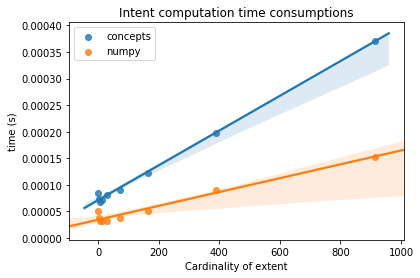

In [25]:
xaxis = list(np.logspace(0,np.log(len(context_bin.index)+1), 20).round().astype(int))
y_conc = []
y_pand = []

for x in tqdm_notebook(xaxis):
    times_conc = []
    times_pand = []
    
    max_iter = 1000
    combs = list(islice(combinations(context_bin.index, x),max_iter))
    if len(combs)<max_iter:
        combs = combs*max_iter
        combs = combs[:max_iter]
    for comb in tqdm_notebook(combs,  desc=f'x: {x}', leave=True, disable=True):    
        comb = list(comb)
        dt1 = datetime.now()
        c_.intension(comb)
        dt2 = datetime.now()
        times_conc.append((dt2-dt1).total_seconds())
        
        comb_int = [objs_dict[m] for m in comb]
        
        dt1 = datetime.now()
        get_intent(comb_int, context_bin_matr)
        dt2 = datetime.now()
        times_pand.append((dt2-dt1).total_seconds())
        
        
    y_conc.append(np.mean(times_conc))
    y_pand.append(np.mean(times_pand))

sns.regplot(xaxis, y_conc, label='concepts')
sns.regplot(xaxis, y_pand, label='numpy')
plt.title('Intent computation time consumptions')
#sns.regplot(xaxis, y_pand_2, label='pands2')
#plt.xticks(xaxis, xaxis)
plt.xlabel('Cardinality of extent')
plt.ylabel('time (s)')
plt.legend()
plt.show()

In [26]:
context_bin_matr.T.shape

(16, 1131)

In [27]:
context_bin_matr.shape

(1131, 16)

In [28]:
is_transposed = False

In [29]:
any([False, ])

False

In [30]:
def close_by_one(cntx):
    is_transposed = False
    if cntx.shape[0]<cntx.shape[1]:
        cntx = cntx.T
        is_transposed = True
        
    combs_to_check = [[]]#[[i] for i in range(cntx.shape[1])]
    concepts = set()
    while len(combs_to_check)>0:
        comb = combs_to_check.pop(0)
        ext_ = get_extent(comb, cntx)
        int_ = get_intent(ext_, cntx)
        new_int_ = [x for x in int_ if x not in comb]
        if len(comb)>0 and any([x<comb[-1] for x in new_int_]):
            continue
        concepts.add((tuple(ext_), tuple(int_)))
        
        combs_to_check = [int_+[x] for x in range((int_[-1] if len(int_)>0 else -1)+1, cntx.shape[1])]+combs_to_check
    
    concepts = [(x[1],x[0]) for x in list(concepts)] if is_transposed else list(concepts)
    concepts = sorted(concepts, key=lambda x: len(x[1]))
    
    return concepts

In [31]:
xaxis = list(np.linspace(1,len(context_bin_matr),50).astype(int))#[1,10,100,300,1000]
times = []
for x in tqdm_notebook(xaxis):
    dt1 = datetime.now()
    close_by_one(context_bin_matr[:x])
    dt2 = datetime.now()
    times.append((dt2-dt1).total_seconds())

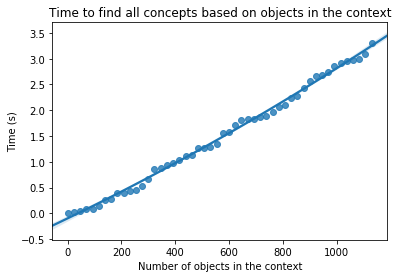

In [32]:
sns.regplot(xaxis, times, order=2)
plt.xlabel('Number of objects in the context')
plt.ylabel('Time (s)')
plt.title('Time to find all concepts based on objects in the context')
plt.show()

In [33]:
%%time
concepts_set = close_by_one(context_bin_matr)
print('Num of concepts: ',len(concepts_set))

Num of concepts:  24794
CPU times: user 3.05 s, sys: 71.1 ms, total: 3.12 s
Wall time: 3.03 s


In [34]:
attrs_dict_inv = {v:k for k,v in attrs_dict.items()}
[(len(x[0]),[attrs_dict_inv.get(f,f) for f in x[1]]) for x in  sorted(list(concepts_set), key=lambda x:len(x[1])) if attrs_dict['job'] in x[1]][:10]

[(384, ['job']),
 (323, ['job', 'marital']),
 (172, ['job', 'day']),
 (308, ['job', 'default']),
 (309, ['job', 'education']),
 (257, ['job', 'month']),
 (140, ['job', 'pdays']),
 (190, ['job', 'balance']),
 (212, ['job', 'age']),
 (301, ['job', 'loan'])]

In [35]:
def is_subconcept(a,b):
    """if a is subconcept of b, a<=b"""
    return all([g in b[0] for g in a[0]]) and all([m in a[1] for m in b[1]])

In [100]:
def get_lower_neighbours(concepts_set, use_tqdm=True):
    concepts_set = sorted(concepts_set, key=lambda x: len(x[0]))
    concepts_map = {k:i for i,k in enumerate(concepts_set)}
    lower_neighbours = {concepts_map[concepts_set[0]]: []}
    
    for idx, concept in tqdm_notebook(enumerate(concepts_set[1:]), total=len(concepts_set)-1, disable=not use_tqdm):
        possible_neighbs = concepts_set[:idx][::-1]
        neighbs = set()
                    
        for pn in tqdm_notebook(possible_neighbs,leave=True, disable=True):
            if pn in neighbs:
                continue
            if is_subconcept(pn, concept):
                neighbs = neighbs|{concepts_map[pn]}|set(lower_neighbours[concepts_map[pn]])
        lower_neighbours[concepts_map[concept]] = tuple([n for n in neighbs])
    return lower_neighbours

In [103]:
lower_neighbours = get_lower_neighbours(concepts_set)

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f685bc41c00>
Traceback (most recent call last):
  File "/home/egor/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


KeyboardInterrupt: 

In [102]:
import json
with open('bank_lower_neighbours.json','w') as f:
    json.dump(lower_neighbours,f)

### Multiple feature nose

Find every combination of the features that significatly infuence the output

### Using SHAP
https://github.com/slundberg/shap

SHAP is one of the most popular techniques of interpretation. May be we can use it?

#### Shap features importances

#### Shap feature _values_ importances